In [1]:
import itertools
import pandas as pd
import numpy as np
import os
import random 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU,SimpleRNN, RNN, Input, Bidirectional
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from sklearn.model_selection import GroupKFold

from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_squared_error as mse

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [2]:
# general settings
class CFG:
    data_folder = 'data/'
    img_dim1 = 20
    img_dim2 = 10
    nepochs = 6
    seed = 42
    EPOCH = 300
    bsize = 16
    BATCH_SIZE = 1024

    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   


def seed_everything(seed: int = 42) -> None:
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(CFG.seed)

# Functions

In [3]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [4]:
def create_dataset(dataset, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back -look_ahead):
        xdat.append(df[i:i+ look_back ,0])
        ydat.append(df[i+ look_back : i + look_back + look_ahead,0])
    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1,look_ahead)
    return xdat, ydat

In [5]:
def prepare_split(xdat, ydat, cutoff = 5000, timesteps = 50):
    xtrain, xvalid = xdat[:cutoff,:], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff,:], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid 


<AxesSubplot:>

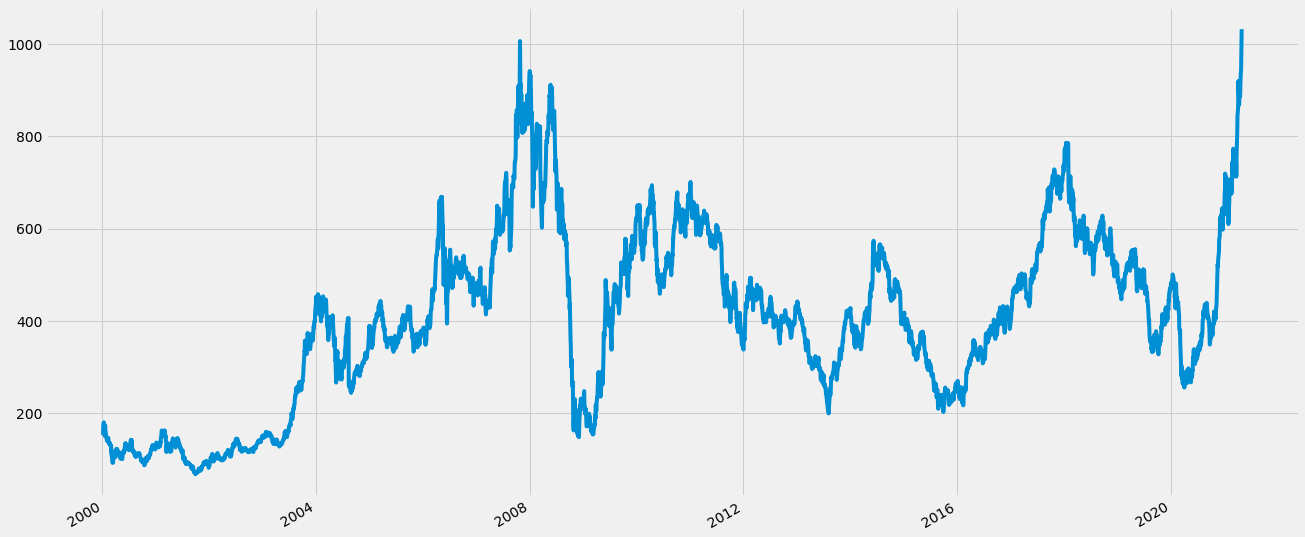

In [6]:
# load the dataset
stock_name = 'TATASTEEL'

df = pd.read_csv('data/'+stock_name+'.csv', usecols = ['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index("Date",  inplace=True)
df.VWAP.plot(xlabel = '')

In [7]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [8]:
# use 50 historical observations, predict 1 step ahead
look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

# We only want to forecast a single value for each series => target is a column
print(xdat.shape, ydat.shape)


(5255, 50) (5255, 1)


In [9]:

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(5000, 50, 1) (255, 50, 1) (5000, 1) (255, 1)


In [10]:
def create_model1():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model1 = create_model1()


In [11]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model1.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

Epoch 1/6
313/313 [==============================] - 11s 29ms/step - loss: 0.0586 - val_loss: 0.0195
Epoch 2/6
313/313 [==============================] - 9s 29ms/step - loss: 0.0064 - val_loss: 0.0078
Epoch 3/6
313/313 [==============================] - 9s 29ms/step - loss: 0.0027 - val_loss: 0.0025
Epoch 4/6
313/313 [==============================] - 9s 28ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/6
313/313 [==============================] - 9s 29ms/step - loss: 8.4287e-04 - val_loss: 0.0017
Epoch 6/6
313/313 [==============================] - 9s 28ms/step - loss: 6.9801e-04 - val_loss: 0.0014


In [13]:
# predict and calculate RMSE
y_pred1 = model1.predict(xvalid)
y_pred1 = scaler.inverse_transform(y_pred1)
yvalid1 =  scaler.inverse_transform(yvalid)


In [14]:
print('RMSE: ' + str(my_rmse(y_pred1, yvalid1)))

RMSE: 36.4864


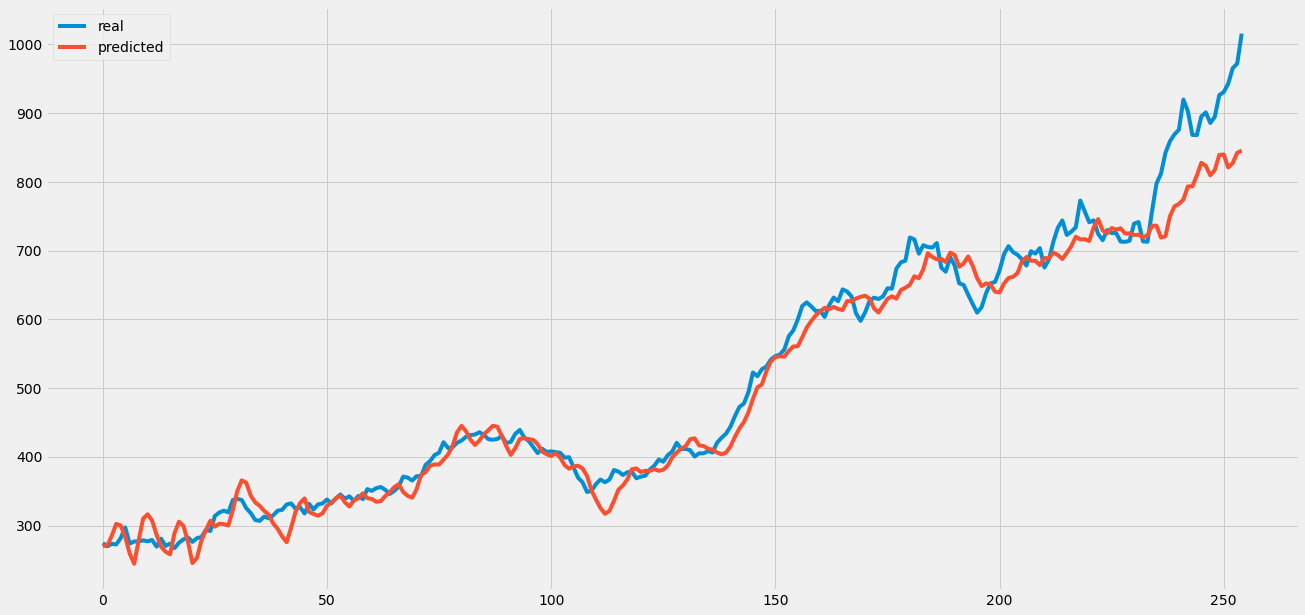

In [15]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred1, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

In [16]:
# def create_model2():    
    
#     model=Sequential()
#     model.add(SimpleRNN(10,input_shape= [None,1]))
#     model.add(SimpleRNN(10,input_shape= [None,1]))
#     model.add(Dense(1))
    
#     model.compile(loss='mean_squared_error',optimizer='adam')
#     return model
    
# model2 = create_model2()
# model2.summary()

In [17]:
def create_model2():    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(1))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model2 = create_model2()
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [18]:
model2.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred2 = model2.predict(xvalid)
y_pred2 = scaler.inverse_transform(y_pred2)
print('RMSE: ' + str(my_rmse(y_pred2, scaler.inverse_transform(yvalid))))

Epoch 1/6
313/313 [==============================] - 22s 67ms/step - loss: 0.0114 - val_loss: 0.0021
Epoch 2/6
313/313 [==============================] - 21s 66ms/step - loss: 5.7358e-04 - val_loss: 0.0011
Epoch 3/6
313/313 [==============================] - 21s 66ms/step - loss: 3.3896e-04 - val_loss: 6.1632e-04
Epoch 4/6
313/313 [==============================] - 21s 66ms/step - loss: 2.9083e-04 - val_loss: 6.0065e-04
Epoch 5/6
313/313 [==============================] - 21s 66ms/step - loss: 2.5506e-04 - val_loss: 3.9777e-04
Epoch 6/6
313/313 [==============================] - 21s 66ms/step - loss: 2.3437e-04 - val_loss: 3.4418e-04
RMSE: 17.8839


In [19]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

print(xdat.shape, ydat.shape)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)


(5246, 50) (5246, 10)
(5000, 50, 1) (246, 50, 1) (5000, 10) (246, 10)


In [20]:
def create_model3(out_dim):    
    
    model=Sequential()
    model.add(SimpleRNN(10,input_shape= [None,1], return_sequences = True))
    model.add(SimpleRNN(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model3 = create_model3(out_dim = look_ahead)
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_3 (SimpleRNN)     (None, None, 10)          120       
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
Total params: 440
Trainable params: 440
Non-trainable params: 0
_________________________________________________________________


In [21]:
model3.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred3 = model3.predict(xvalid)
y_pred3 = scaler.inverse_transform(y_pred3)

Epoch 1/6
313/313 [==============================] - 22s 67ms/step - loss: 0.0292 - val_loss: 0.0086
Epoch 2/6
313/313 [==============================] - 21s 66ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 3/6
313/313 [==============================] - 21s 67ms/step - loss: 0.0027 - val_loss: 0.0037
Epoch 4/6
313/313 [==============================] - 21s 66ms/step - loss: 0.0020 - val_loss: 0.0033
Epoch 5/6
313/313 [==============================] - 21s 66ms/step - loss: 0.0017 - val_loss: 0.0031
Epoch 6/6
313/313 [==============================] - 21s 66ms/step - loss: 0.0015 - val_loss: 0.0023


In [22]:
print('RMSE: ' + str(my_rmse(y_pred3, scaler.inverse_transform(yvalid))))

RMSE: 46.6633


In [23]:
def create_model4(out_dim):    
    
    model=Sequential()
    model.add(GRU(10,input_shape= [None,1], return_sequences = True))
    model.add(GRU(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model4 = create_model4(out_dim = look_ahead)
model4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                660       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
Total params: 1,160
Trainable params: 1,160
Non-trainable params: 0
_________________________________________________________________


In [24]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)



In [25]:
model4.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred4 = model4.predict(xvalid)
y_pred4 = scaler.inverse_transform(y_pred4)


Epoch 1/6
313/313 [==============================] - 6s 8ms/step - loss: 0.0212 - val_loss: 0.0033
Epoch 2/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0019
Epoch 3/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 4/6
313/313 [==============================] - 2s 6ms/step - loss: 9.7100e-04 - val_loss: 0.0024
Epoch 5/6
313/313 [==============================] - 2s 6ms/step - loss: 9.4397e-04 - val_loss: 0.0020
Epoch 6/6
313/313 [==============================] - 2s 6ms/step - loss: 9.0772e-04 - val_loss: 0.0023


In [26]:
print('RMSE: ' + str(my_rmse(y_pred4, scaler.inverse_transform(yvalid))))

RMSE: 46.6173


In [27]:
def create_model5(out_dim):    
    
    model=Sequential()
    model.add(LSTM(10,input_shape= [None,1], return_sequences = True))
    model.add(LSTM(10,input_shape= [None,1]))
    model.add(Dense(out_dim))
    
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model
    
model5 = create_model5(out_dim = look_ahead)
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 10)          480       
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
Total params: 1,430
Trainable params: 1,430
Non-trainable params: 0
_________________________________________________________________


In [28]:
look_back = 50
look_ahead = 10

xdat, ydat = create_dataset(df, look_back = look_back, look_ahead = look_ahead)

xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 5000, timesteps= look_back)


In [29]:
model5.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), 
                  epochs = CFG.nepochs, batch_size = CFG.bsize, callbacks=[ early_stop])

y_pred5 = model5.predict(xvalid)
y_pred5 = scaler.inverse_transform(y_pred5)

Epoch 1/6
313/313 [==============================] - 5s 9ms/step - loss: 0.0189 - val_loss: 0.0042
Epoch 2/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 3/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0016 - val_loss: 0.0033
Epoch 4/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 5/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0013 - val_loss: 0.0025
Epoch 6/6
313/313 [==============================] - 2s 6ms/step - loss: 0.0012 - val_loss: 0.0023


In [30]:
print('RMSE: ' + str(my_rmse(y_pred5, scaler.inverse_transform(yvalid))))

RMSE: 46.2989
